# Прогнозирование зарплаты кандидата

## Содержание: <a class="anchor" id="toc"></a>
* [Задача](#zero-bullet)
* [Загрузка данных](#upload)
* [Подробный EDA](#first-bullet)
    * [Распределение таргета](#f-bul)
    * [Распределение категориальных признаков](#s-bul)
    * [Корреляции признаков](#t-bul)
    * [Распределение признаков в тестовой выборке](#fo-bul)
* [Предобработка текста](#third-bullet)
    * [Текстовые признаки](#ff-bul)
    * [Подготовка текстовых признаков](#ss-bul)
* [W2Vec](#fourth-bullet)
* [Обучение моделей](#fifth-bullet)
* [Тестирование](#sixth-bullet)
* [Вывод](#seventh-bullet)

## Задача <a class="anchor" id="zero-bullet"></a>

Необходимо обучить модель, предсказывающую, на которую может рассчитывать кандидат, по описанию вакансии в сервисе для поиска работы. В нашем распоряжении обучающая и тестовая выборки с платформы [Kaggle](https://www.kaggle.com/competitions/hse-2nd-step-in-nlp-bootcamp/leaderboard): файлы `vacancies_train.csv` и `vacancies_test.csv`. Значения целевого признака тестовой выборки скрыты, качество предсказания будет оцениваться непосредственно при загрузке результата на платформу.

Решается **задача регрессии** c текстовыми признаками. **Метрика качества** *R2*. 

Организаторами соревнования предоставлен [baseline](https://colab.research.google.com/drive/1UVqMgXW1YD8F9osT_DFY2oYoIxfNKHuX?usp=sharing) с метрикой `R2 = 0.29`. Цель проекта получить метрику выше. 

## План 

Для достижения цели выполним следующие шаги:

1. **Подробный EDA**:
    1. изучим распределения признаков и целевого признака в обучающей выборке
    2. изучим корреляции признаков
    3. изучим распределения признаков в тестовой выборке
    
2. **Предобработка текста**: сделаем эмбеддинг текстовых признаков
    
3. **Обучение**: проведем кросс-валидацию моделей и выберем лучшую.
4. **Тестирование**: сделаем предсказания на тестовой выборке и загрузим результат на Kaggle, чтобы определить метрику на тесте.

In [1]:
#!pip install pymorphy2

In [2]:
#!pip install gensim

In [3]:
#!pip install optuna

In [2]:
# basic packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# preprocessing and validation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

# models
from catboost import CatBoostRegressor

# text preprocessing
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
from gensim.models import Word2Vec

# helper packages
import phik
import optuna
from ast import literal_eval
from tqdm import tqdm
tqdm.pandas()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alfic\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alfic\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alfic\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\alfic\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Загрузка данных <a class="anchor" id="upload"></a>

In [3]:
# загрузка обучающей выборки
df_train = pd.read_csv('vacancies_train.csv')
df_train.sample(5)

,name,experience,schedule,employment,description,key_skills,salary
7110,Бариста,От 1 года до 3 лет,Гибкий график,Полная занятость,Coffeebrain сеть современных кофеен которая жд...,[],50000.0
15330,Врач-хирург,Нет опыта,Сменный график,Полная занятость,Работа на территории работодателя: р-н Анапски...,[],15000.0
6217,"Кассир в ресторан ""Хочу харчо""",От 1 года до 3 лет,Сменный график,Полная занятость,Обязанности: Осуществление операций по прием...,[],35000.0
15288,Мастер ногтевого сервиса,От 1 года до 3 лет,Полный день,Полная занятость,"Обязанности: • маникюр, педикюр, моделирован...",['Обучение и развитие'],100000.0
16380,Медицинская сестра процедурного кабинета,От 1 года до 3 лет,Сменный график,Частичная занятость,"Многопрофильная клиника ""Дункан"" приглашает в ...","['Медицинская документация', 'Работа в команде...",20000.0


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16629 entries, 0 to 16628
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         16629 non-null  object 
 1   experience   16629 non-null  object 
 2   schedule     16629 non-null  object 
 3   employment   16629 non-null  object 
 4   description  16629 non-null  object 
 5   key_skills   16629 non-null  object 
 6   salary       16629 non-null  float64
dtypes: float64(1), object(6)
memory usage: 909.5+ KB


In [5]:
# загрузка тестовой выборки
df_test = pd.read_csv('vacancies_test.csv', index_col=0)
df_test.sample(5)

,name,experience,schedule,employment,description,key_skills
id,,,,,,
1604,Контролер отк в производстве черных металлов,От 3 до 6 лет,Вахтовый метод,Полная занятость,Обязанности: Визуальный осмотр наружной и вну...,[]
4510,Координатор (ассистент) отдела продаж,От 1 года до 3 лет,Полный день,Полная занятость,Smart Company – Производственно - торговая гру...,"['1С: Предприятие 8', 'MS Outlook', 'Документо..."
2706,Врач-терапевт участковый (г.Лыткарино),Нет опыта,Сменный график,Полная занятость,Обязанности: Оказание населению медицинской по...,[]
2985,Директор по персоналу,Более 6 лет,Полный день,Полная занятость,Информация о компанииОснована в 2001 году. Сфе...,"['Мотивация персонала', 'Управление проектами'..."
2296,Производитель работ/Мастер СМР,От 3 до 6 лет,Вахтовый метод,Полная занятость,"Место работы ОП г. Полярные Зори, Мурманская о...","['Работа в команде', 'Организаторские навыки',..."


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5543 entries, 0 to 5542
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         5543 non-null   object
 1   experience   5543 non-null   object
 2   schedule     5543 non-null   object
 3   employment   5543 non-null   object
 4   description  5543 non-null   object
 5   key_skills   5543 non-null   object
dtypes: object(6)
memory usage: 303.1+ KB


[Содержание](#toc)

# EDA <a class="anchor" id="first-bullet"></a>

## Распределение таргета <a class="anchor" id="f-bul"></a>

Для начала посмотрим на распределение таргета в трейне. Построим гистограмму и boxplot.

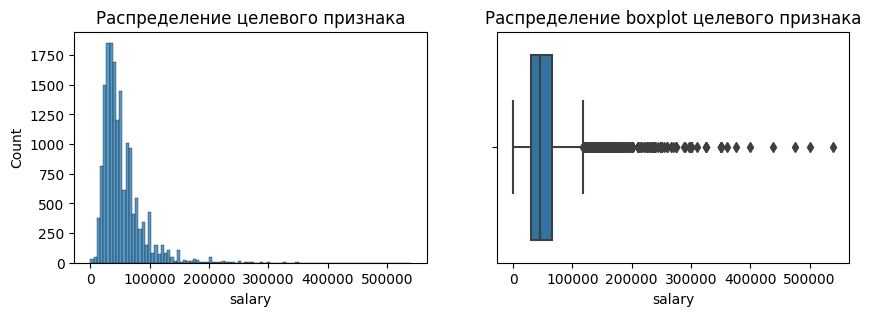

In [9]:
_, axes = plt.subplots(1, 2, figsize=(10,3))

sns.histplot(df_train.salary, bins=100, ax=axes[0])
axes[0].set_title('Распределение целевого признака')

sns.boxplot(x=df_train.salary, ax=axes[1])
axes[1].set_title('Распределение boxplot целевого признака')

plt.show()

Распределение сильно несимметричное: есть длинный хвост в области больших зарплат. Построим распределение в логарифмическом масштабе.

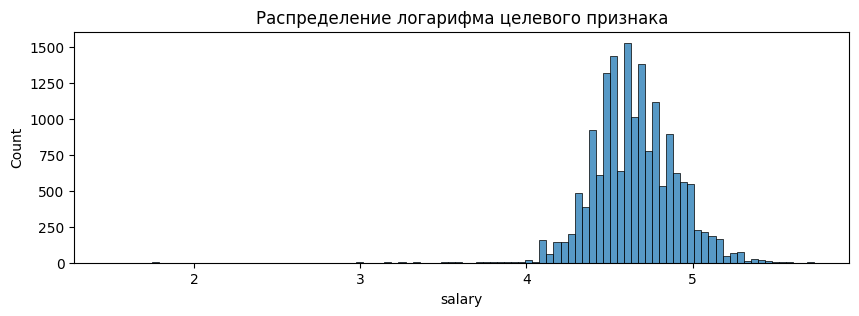

In [11]:
_ = plt.figure(figsize=(10,3))
sns.histplot(np.log10(df_train.salary + 1), bins=100)
plt.title('Распределение логарифма целевого признака')
plt.show()

Распределение по форме стало ближе к нормальному, но есть некоторое количество объектов с аномально низкими зарплатами. Посмотрим на объекты с `log10(df_train.salary + 1) <= 4`.

In [12]:
# выводим нужные объекты
df_train[np.log10(df_train.salary + 1) <= 4]

,name,experience,schedule,employment,description,key_skills,salary
163,Ведущий специалист/Руководитель тендерного отдела,От 3 до 6 лет,Полный день,Полная занятость,Компания-поставщик медицинских расходных матер...,"['Государственные закупки', 'Тендеры', 'Участи...",55.0
275,Сотрудник на пересчет товара,Нет опыта,Гибкий график,Частичная занятость,Для проведения инвентаризации требуется Сотруд...,"['Пользователь ПК', 'Работа в команде', 'Скане...",2100.0
282,Сотрудник на пересчет товара/счетчик-ревизор,Нет опыта,Гибкий график,Частичная занятость,Для проведения инвентаризации требуется СЧЕТЧИ...,"['Пользователь ПК', 'Работа в команде', 'Скане...",2100.0
367,Помощница / Помощник по дому,От 1 года до 3 лет,Полный день,Частичная занятость,Обязанности: Уборка дома Мытье окон Требован...,"['Управление временем', 'Деловая коммуникация']",6000.0
621,Повар-универсал,Нет опыта,Полный день,Полная занятость,Обязанности Повар универсал. Заготовка полуфа...,"['Общественное питание', 'Проведение инвентари...",1800.0
1798,Уборщица/Уборщик,Нет опыта,Полный день,Частичная занятость,"Обязанности: уборка торгового зала, кухни и са...","['Уборка', 'Опрятность']",7200.0
1811,Мерчендайзер,От 1 года до 3 лет,Гибкий график,Частичная занятость,требуется мерчендайзер НА ПОДРАБОТКУ - занятос...,[],8000.0
1890,Секретарь выходного дня,Нет опыта,Полный день,Полная занятость,Обязанности: Встреча клиентов компании Работа...,"['Входящая корреспонденция', 'исходящая коррес...",6000.0
1904,Официант на мероприятия,Нет опыта,Гибкий график,Частичная занятость,Группа компаний WIND TO GO! - это собственный ...,"['Работа в команде', 'Грамотная речь', 'Органи...",800.0
2588,Администратор массажной студии - выходного дня,Нет опыта,Полный день,Частичная занятость,Обязанности: приём и оформление клиентов; про...,"['Пользователь ПК', 'Работа в команде', 'Грамо...",6000.0


In [13]:
# посчитаем количество таких объектов
df_train[np.log10(df_train.salary + 1) <= 4].shape[0]

59

Таких объектов всего 59, удалим эти аномалии.

In [14]:
# удаляем объекты
df_train = df_train.drop(df_train[np.log10(df_train.salary + 1) <= 4].index, axis=0)

In [15]:
# проверяем количество оставшихся
df_train.shape[0]

16570

[Содержание](#toc)

## Распределение категориальных признаков <a class="anchor" id="s-bul"></a>

### Признак `'experience'`

Посмотрим на распределение признака с требуемым опытом работы `'experience'`. Также отобразим boxplot'ы для зарплаты в зависимости от признака `'experience'`.

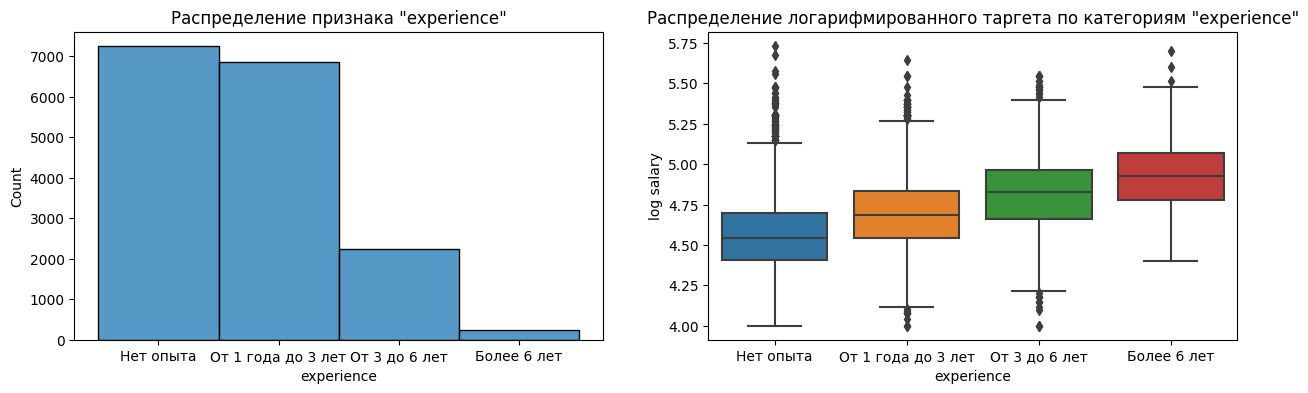

In [16]:
_, axes = plt.subplots(1, 2, figsize=(15, 4))

df_train['experience'] = pd.Categorical(df_train['experience'], ['Нет опыта', 
                                                                 'От 1 года до 3 лет', 
                                                                 'От 3 до 6 лет', 
                                                                 'Более 6 лет'])

sns.histplot(df_train.experience, ax=axes[0])
axes[0].set_title('Распределение признака "experience"')

sns.boxplot(x='experience', y=np.log10(df_train.salary + 1), data=df_train, ax=axes[1])
axes[1].set_ylabel('log salary')
axes[1].set_title('Распределение логарифмированного таргета по категориям "experience"')

plt.show()

Вакансий, в которых опыт работы не требуется, или он минимальный (1-3 года), примерно одинаковое количество. Вакансий с опытом 3-6 лет примерно в 3 раза меньше, а вакансий с опытом более 6 лет совсем мало.
В среднем с ростом требуемого опыта предложение по зарплате растет, но есть достаточно сильный выбросы, особенно в вакансиях без опыта работы.

Посмотрим подробнее на распределение таргета в зависимости от `'experience'`. Сделаем это в логарифмической шкале, чтобы компенсировать длинные "хвосты" распределений.

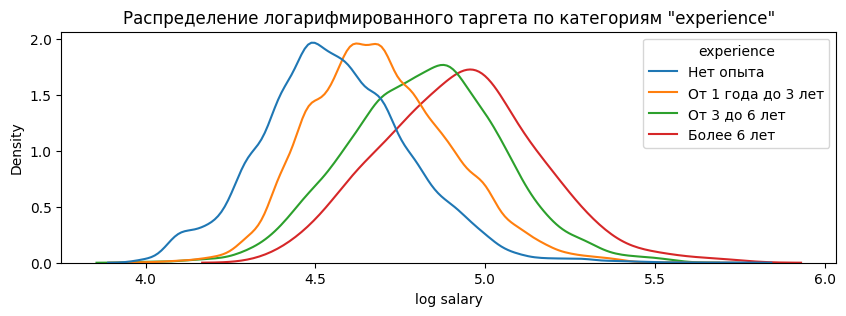

In [17]:
_ = plt.figure(figsize=(10,3))
sns.kdeplot(data=df_train, x=np.log10(df_train.salary + 1), hue='experience', common_norm=False)
plt.xlabel('log salary')
plt.title('Распределение логарифмированного таргета по категориям "experience"')
plt.show()

Здесь подтверждаются выводы о том, что в среднем с ростом требуемого опыта растет зарплата. Форма распределений немного отличается друг от друга, но по-прежнему достаточно близка к нормальному.

### Признак `'schedule'`



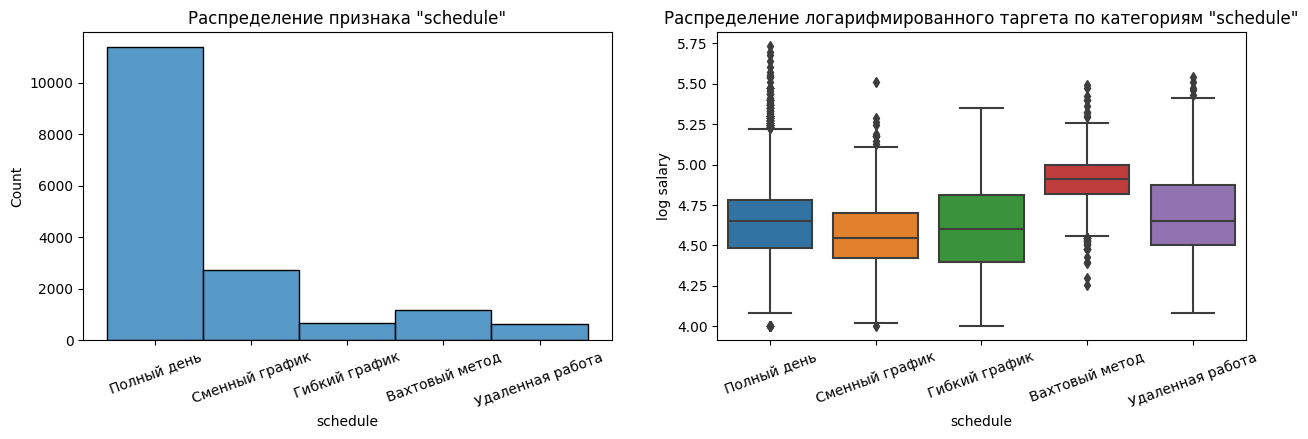

In [18]:
_, axes = plt.subplots(1, 2, figsize=(15, 4))

sns.histplot(df_train.schedule, ax=axes[0])
axes[0].tick_params(axis='x', labelrotation=20)
axes[0].set_title('Распределение признака "schedule"')

sns.boxplot(x='schedule', y=np.log10(df_train.salary + 1), data=df_train, ax=axes[1])
axes[1].tick_params(axis='x', labelrotation=20)
axes[1].set_ylabel('log salary')
axes[1].set_title('Распределение логарифмированного таргета по категориям "schedule"')

plt.show()

Большиство вакансий - с полным рабочим днем. Медианы у всех категорий, кроме вахтового метода, достаточно близко друг к другу.
Заплата в вакансиях с вахтовым методом в среднем заметно выше.

Посмотрим на распределения заплаты в зависимости от рабочего дня.

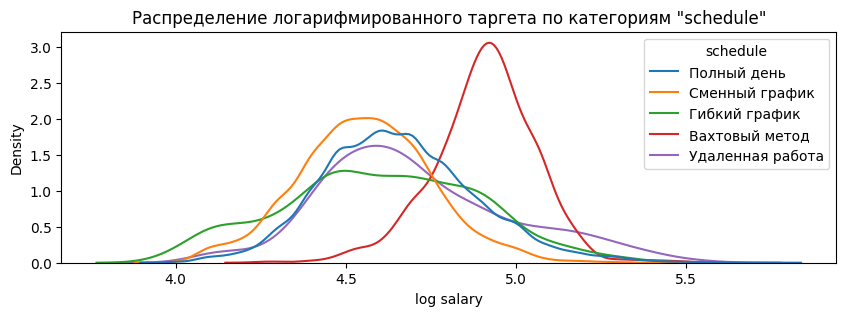

In [19]:
_ = plt.figure(figsize=(10,3))
sns.kdeplot(data=df_train, x=np.log10(df_train.salary + 1), hue='schedule', common_norm=False)
plt.xlabel('log salary')
plt.title('Распределение логарифмированного таргета по категориям "schedule"')
plt.show()

Распределения вакансий с вахтовым методом заметно выделяется - заплаты в них выше и разброс меньше. Распределения вакансий с полным днем и удаленной работой очень похожи. У последних достаточно тяжелый "хвост", который наблюдается даже в логарифмическом масштабе. Возможно, стоит объединить некоторые их этих категорий в одну.

Попробуем объединить все категории, кроме вахтового метода в одну: `'Другой график'`. Сделаем новый признак `'new_schedule'` и посмотрим на распределение таргета по этому признаку.

In [21]:
# функция для преобразования категорий 'schedule'
def schedule_transformer(df_col):
    if df_col == 'Вахтовый метод':
        return 'Вахтовый метод'
    else:
        return 'Другой график'

# строим новый признак 'new_schedule'    
df_train['new_schedule'] = df_train['schedule'].apply(schedule_transformer)

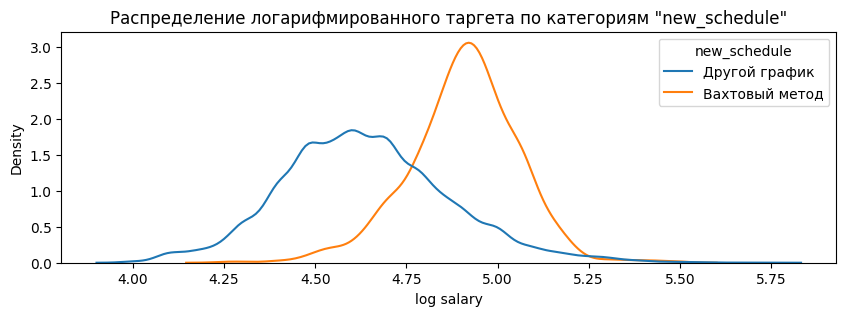

In [22]:
_ = plt.figure(figsize=(10,3))
sns.kdeplot(data=df_train, x=np.log10(df_train.salary + 1), hue='new_schedule', common_norm=False)
plt.xlabel('log salary')
plt.title('Распределение логарифмированного таргета по категориям "new_schedule"')
plt.show()

Распределения достаточно хорошо разделяются, поэтому будем использовать этот синтетический признак.

### Признак `'employment'`



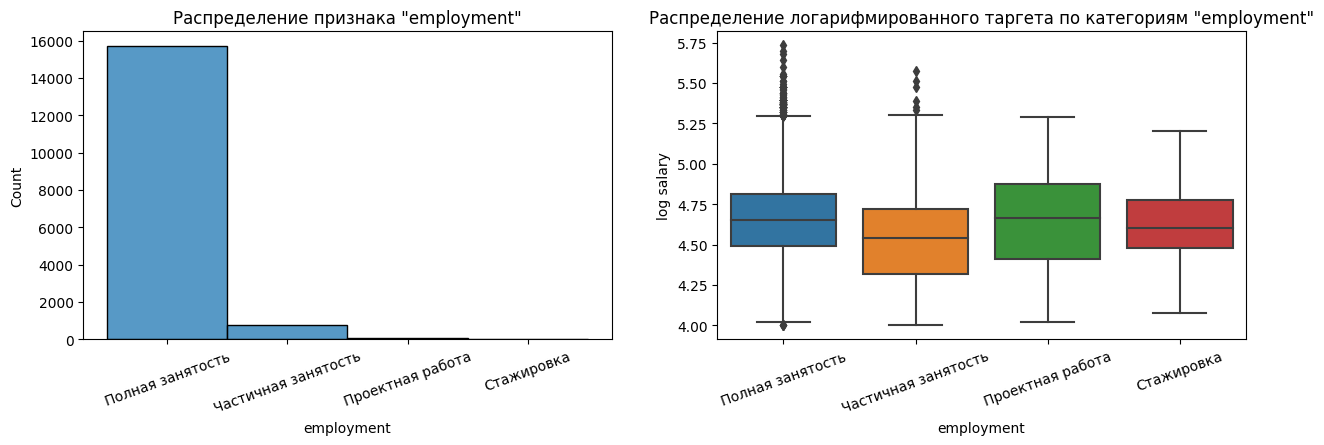

In [23]:
_, axes = plt.subplots(1, 2, figsize=(15, 4))

sns.histplot(df_train.employment, ax=axes[0])
axes[0].tick_params(axis='x', labelrotation=20)
axes[0].set_title('Распределение признака "employment"')

sns.boxplot(x='employment', y=np.log10(df_train.salary + 1), data=df_train, ax=axes[1])
axes[1].tick_params(axis='x', labelrotation=20)
axes[1].set_ylabel('log salary')
axes[1].set_title('Распределение логарифмированного таргета по категориям "employment"')

plt.show()

Почти все вакансии - с полной занятостью, вакансий в других группах менее 5 %. При этом нет выделяющихся boxplot'ам значений признака. 

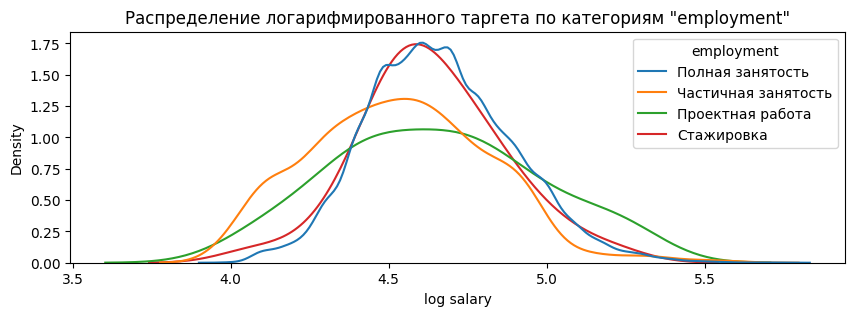

In [24]:
_ = plt.figure(figsize=(10,3))
sns.kdeplot(data=df_train, x=np.log10(df_train.salary + 1), hue='employment', common_norm=False)
plt.xlabel('log salary')
plt.title('Распределение логарифмированного таргета по категориям "employment"')
plt.show()

Здесь подтверждается, что распределения целевого признака достаточно близки друг к другу. Распределения для вакансий с полной занаятостью и стажировками вообще практически совпадают, только в первом больше выбросов. Этот признак не кажется очень полезным, его рассматривать не будем.

[Содержание](#toc)

## Корреляции признаков <a class="anchor" id="t-bul"></a>

Изучим корреляции рассмотренных признаков друг с другом и с таргетом.

In [26]:
# считаем корреляции
phik_corr = df_train[['experience', 'schedule', 'new_schedule', 'employment', 'salary']].phik_matrix()

interval columns not set, guessing: ['salary']


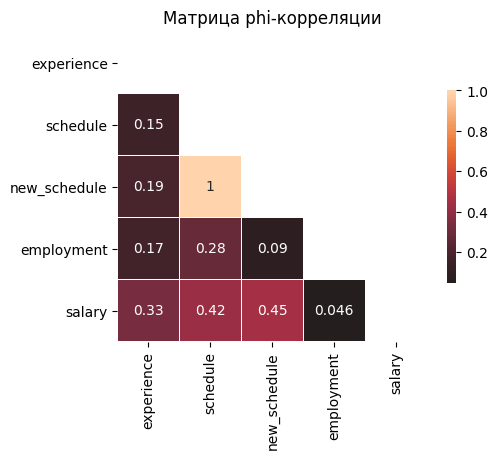

In [27]:
mask = np.triu(np.ones_like(phik_corr, dtype=bool))
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(phik_corr, mask=mask, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.title('Матрица phi-корреляции')
plt.show()

Сильной корреляции между признаками нет, если не считать закономерную корреляцию между синтетическим признаком `'new_schedule'` и признаком `'schedule'`. Корреляция таргета с признаком `'new_schedule'` выше, поэтому будем использовать его. Корреляция таргета с признаком `'experience'` также неплохая, а вот корреляция с признаком `'employment'` слабая. Поэтому сделанный ранее вывод о том, что этот признак не будет полезен, подтверждается.

**Вывод**:

Таким образом, из категориальных признаков будем использовать для обучения модели признаки `'experience'` и `'new_schedule'`.

## Распределения признаков в тестовой выборке <a class="anchor" id="fo-bul"></a>

Посмотрим на распределения этих признаков в тестовой выборке. Сначала построим аналогичный синтетичесткий признак `'new_schedule'`.

In [28]:
# строим признак 'new_schedule' в тестовой выборке
df_test['new_schedule'] = df_test['schedule'].apply(schedule_transformer)

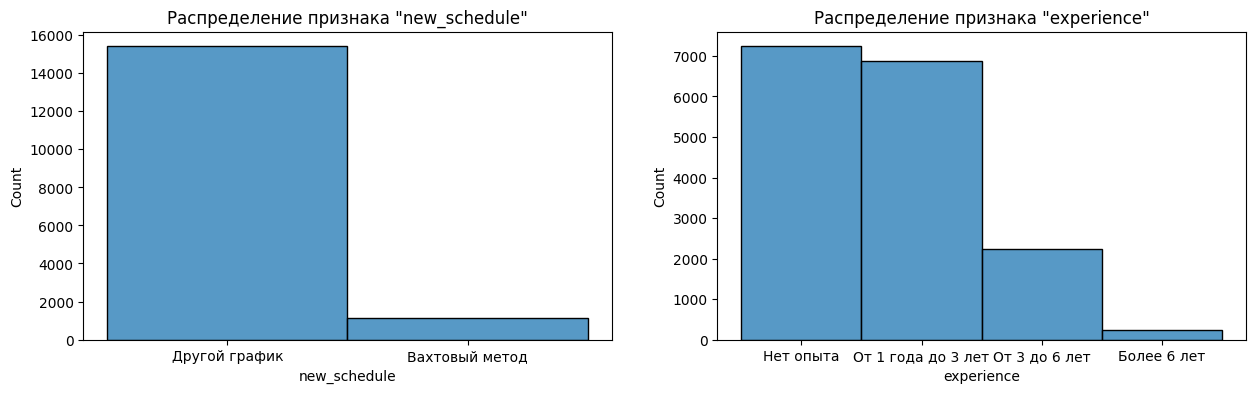

In [29]:
_, axes = plt.subplots(1, 2, figsize=(15, 4))

sns.histplot(df_train.new_schedule, ax=axes[0])
axes[0].set_title('Распределение признака "new_schedule"')
sns.histplot(df_train.experience, ax=axes[1])
axes[1].set_title('Распределение признака "experience"')

plt.show()

**Вывод**:

Распределения похожи на распределения в обучающей выборке, поэтому эти признаки можно использовать для обучения модели.

[Содержание](#toc)

# Предобработка текста <a class="anchor" id="third-bullet"></a>

## Текстовые признаки <a class="anchor" id="ff-bul"></a>

### Признак `'name'`

Посмотрим на уникальные значения признака `'name'`.

In [27]:
df_train.name.value_counts()

Менеджер по продажам                                            208
Продавец-консультант                                            180
Кладовщик                                                       111
Менеджер по работе с клиентами                                  111
Бухгалтер                                                       108
                                                               ... 
Фармацевт-провизор (в Крым)                                       1
Менеджер по работе с юридическими лицами (Маркетплейс)            1
Специалист в службу поддержки персональных сервисов               1
Менеджер по развитию (проектные продажи систем безопасности)      1
Менеджер по работе с клиентами - помощник руководителя            1
Name: name, Length: 9879, dtype: int64

В этом поле почти 10 тысяч уникальных значений, поэтому его надо обрабатывать как текстовый признак. Для кодирования этого признака будем использовать `CountVectorizer`. Кодировать будем отдельно от других текстов.

### Признак `'key_skills'`

Посмотрим, как часто различные требуемые навыки встречаются в поле `key_skills`. 

In [28]:
# создаем словарь
skills_count = dict()

# вносим в словарь навыки
for skill_list in df_train.key_skills:
    list_of_skills = literal_eval(skill_list)
    for skill in list_of_skills:
        if skill not in skills_count:
            skills_count[skill] = 1
        else:
            skills_count[skill] += 1

# сортируем по частоте упоминания
skills_count = {k: v for k, v in sorted(skills_count.items(), key=lambda item: item[1], reverse=True)}

skills_count

{'Работа в команде': 2759,
 'Пользователь ПК': 2625,
 'Грамотная речь': 2217,
 'Умение работать в команде': 1143,
 'Активные продажи': 1065,
 'Деловое общение': 850,
 'Навыки продаж': 700,
 'Телефонные переговоры': 648,
 'Ведение переговоров': 629,
 'Организаторские навыки': 586,
 'Деловая переписка': 522,
 'Клиентоориентированность': 513,
 'Обучение и развитие': 494,
 'Поиск и привлечение клиентов': 479,
 'Грамотность': 461,
 'Работа с большим объемом информации': 419,
 'Прямые продажи': 402,
 'Заключение договоров': 356,
 'Холодные продажи': 352,
 'Ориентация на результат': 349,
 'AutoCAD': 344,
 'Управление персоналом': 342,
 'Консультирование': 340,
 '1С: Предприятие 8': 323,
 'Обучение персонала': 322,
 'Работа с людьми': 301,
 'Водительское удостоверение категории B': 289,
 'Навыки межличностного общения': 283,
 'Деловая коммуникация': 281,
 'Работа с кассой': 278,
 'Знание устройства автомобиля': 274,
 'Медицинская документация': 265,
 'Умение работать в коллективе': 262,
 'Англ

In [29]:
# считаем уникальные значения
len(skills_count)

4343

В этом признаке немного меньше уникальных значений, и те значения, которые встречаются часто, в основном очень общие и размытые. Поэтому для кодирования этого признака будем использовать TF-IDF. При этом есть специфические значения на английском языке, поэтому в предобработке необходимо оставить латиницу.

### Признак `'description'`

Посмотрим на пример значения поля с описанием вакансии.

In [30]:
print(df_train.description.values[1])

Обязанности:   Списывание материалов в производство Прием ТМЦ, разгрузка товара Оприходование материалов и готовой продукции на склад Размещение материалов на складе Ведение документооборота Контроль складских остатков Составление заявок на пополнения складских остатков Ведение номенклатуры в базе 1С Обеспечение сохранности ТМЦ Поддержание порядка на складе.  Требования:  Знание программы 1с Внимательность, аккуратность Умение работать в команде Знание номенклатуры металлопроката будет преимуществом  Условия:  отличный коллектив, людей, которые ответственно относятся к своей работе, отвечают каждый за свою работу и результат, у нас точно не получится просто "отбывать номер", мы платим зарплату по верхней планке за работу есть опытный кладовщик, который всё покажет, инструкции по выполнению всех операций в 1С быстро растущая торгово-производственная компания, лидер рынка производства дизайнерского света и инсталляций производим светильники высокого качества по индивидуальным заказам. ис

**Вывод**:

Для кодирования признака `'name'` будем использовать `CountVectorizer`, для кодирования `key_skills` - `TfidfVectorizer`, а для кодирования `description` обучим `Word2Vec`, эмбеддинги которого будет усреднять с помощью TF-IDF. Сначала необходимо подготовить все текстовые признаки.

[Содержание](#toc)

## Подготовка текстовых признаков <a class="anchor" id="ss-bul"></a>

Сначала подготовим признак `'description'`. Оставим только кириллицу, приведем к нижнему регистру, токенизируем, удалим стоп-слова и короткие токены.

In [31]:
# создаем набор стоп-слов
stop_words = set(stopwords.words('russian'))
morph = MorphAnalyzer()

# функция для очистки описаний
def clean_text(text):
    text = re.sub(r'http\S+', '', text) # избавляемся от ссылок
    text = re.sub('[^а-яёА-ЯЁ]', ' ', text) # оставляем только кириллицу
    text = word_tokenize(text.lower()) # приводим к нижнему регистру и токенизируем по словам
    # приводим токены к нормальной форме, удаляем стоп-слова и короткие токены
    text = [morph.normal_forms(token)[0] for token in text 
            if token not in stop_words and len(token) >= 2]
    text = " ".join(text) # возвращаем строку
    return text

In [32]:
# применяем к обучающей выборке
df_train['description_cleaned'] = df_train.description.progress_apply(clean_text)
df_train.head()

100%|██████████| 16570/16570 [06:34<00:00, 41.96it/s]


,name,experience,schedule,employment,description,key_skills,salary,new_schedule,description_cleaned
0,Водитель-экспедитор,От 3 до 6 лет,Полный день,Полная занятость,"Водитель-экспедитор категории В,С (а\м ГАЗЕЛЬ ...",[],42500.0,Другой график,водитель экспедитор категория газель тент газе...
1,Кладовщик-комплектовщик/оператор 1С,От 1 года до 3 лет,Полный день,Полная занятость,Обязанности: Списывание материалов в произво...,"['знание пк', 'работа в 1С', 'Работа в команде...",50000.0,Другой график,обязанность списывание материал производство п...
2,"Продавец магазина ""Магнит"" (Кировский р-он, В....",Нет опыта,Сменный график,Полная занятость,"В крупнейшую Федеральную сеть магазинов ""Магни...",[],31500.0,Другой график,крупный федеральный сеть магазин магнит требов...
3,Администратор магазина (ТЦ Spar),От 1 года до 3 лет,Полный день,Полная занятость,Крупная федеральная сеть магазинов мужской и ж...,[],36700.0,Другой график,крупный федеральный сеть магазин мужской женск...
4,Мойщик посуды (кулинария),Нет опыта,Сменный график,Полная занятость,Обязанности: Уборка производственных площадей...,"['Пользователь ПК', 'Грамотная речь', 'Работа ...",37000.0,Другой график,обязанность уборка производственный площадь ку...


In [33]:
# применяем к тестовой выборке
df_test['description_cleaned'] = df_test.description.progress_apply(clean_text)
df_test.head()

100%|██████████| 5543/5543 [02:08<00:00, 43.25it/s]


,name,experience,schedule,employment,description,key_skills,new_schedule,description_cleaned
id,,,,,,,,
0,Главный бухгалтер,Более 6 лет,Полный день,Полная занятость,Обязанности:Осуществление организации бухгалте...,"['1С: Предприятие 8', '1C: Предприятие', 'Рабо...",Другой график,обязанность осуществление организация бухгалте...
1,Ассистент врача-стоматолога,От 1 года до 3 лет,Сменный график,Полная занятость,"Обязанности: Ассистировать врачу стоматологу,...","['Пользователь ПК', 'Работа в команде', 'Умени...",Другой график,обязанность ассистировать врач стоматолог подг...
2,Менеджер по продажам,От 1 года до 3 лет,Полный день,Полная занятость,Если ты: хочешь построить карьеру в банковс...,[],Другой график,хотеть построить карьера банковский сектор ори...
3,Менеджер,От 1 года до 3 лет,Полный день,Полная занятость,Динамично развивающаяся на протяжении 17 лет...,"['Оценка потребностей клиентов', 'оформление д...",Другой график,динамично развивающийся протяжение год компани...
4,Администратор хостела,Нет опыта,Сменный график,Полная занятость,ВОЗМОЖНА РАБОТА С ПРОЖИВАНИЕМ Обязанности: Пр...,[],Другой график,возможный работа проживание обязанность приём ...


Теперь подготовим признак `'name'`. В нем нужно сделать аналогичную предобработку, но попробуем оставить слова на английском языке (например, слова IOS или 1C могут быть полезны). 

In [34]:
def clean_name(text):
    text = re.sub(r'http\S+', '', text) # избавляемся от ссылок
    eng_text = re.sub('[^a-zA-Z]', ' ', text) # выделяем латиницу и цифры
    ru_text = re.sub('[^а-яёА-ЯЁ]', ' ', text) # выделяем только кириллицу
    # выделяем '1C':
    c_text = re.search(r'1C', text) 
    if not c_text:
        c_text = re.search(r'1С', text)
    if c_text:
        c_text = c_text.group(0)
    else:
        c_text = ''
    eng_text = word_tokenize(eng_text) # токенизируем
    ru_text = word_tokenize(ru_text.lower()) # приводим к нижнему регистру и токенизируем по словам
    # приводим токены к нормальной форме, удаляем стоп-слова и короткие токены
    ru_text = [morph.normal_forms(token)[0] for token in ru_text 
            if token not in stop_words and len(token) >= 2]
    ru_text = " ".join(ru_text) 
    eng_text = " ".join(eng_text)
    text = " ".join([ru_text, eng_text, c_text]) # ru_text + " " + eng_text + " " + c_text
    
    return text

In [35]:
# применяем к обучающей выборке
df_train['name_cleaned'] = df_train.name.progress_apply(clean_name)
df_train.head()

100%|██████████| 16570/16570 [00:12<00:00, 1292.84it/s]


,name,experience,schedule,employment,description,key_skills,salary,new_schedule,description_cleaned,name_cleaned
0,Водитель-экспедитор,От 3 до 6 лет,Полный день,Полная занятость,"Водитель-экспедитор категории В,С (а\м ГАЗЕЛЬ ...",[],42500.0,Другой график,водитель экспедитор категория газель тент газе...,водитель экспедитор
1,Кладовщик-комплектовщик/оператор 1С,От 1 года до 3 лет,Полный день,Полная занятость,Обязанности: Списывание материалов в произво...,"['знание пк', 'работа в 1С', 'Работа в команде...",50000.0,Другой график,обязанность списывание материал производство п...,кладовщик комплектовщик оператор 1С
2,"Продавец магазина ""Магнит"" (Кировский р-он, В....",Нет опыта,Сменный график,Полная занятость,"В крупнейшую Федеральную сеть магазинов ""Магни...",[],31500.0,Другой график,крупный федеральный сеть магазин магнит требов...,продавец магазин магнит кировский уса
3,Администратор магазина (ТЦ Spar),От 1 года до 3 лет,Полный день,Полная занятость,Крупная федеральная сеть магазинов мужской и ж...,[],36700.0,Другой график,крупный федеральный сеть магазин мужской женск...,администратор магазин тц Spar
4,Мойщик посуды (кулинария),Нет опыта,Сменный график,Полная занятость,Обязанности: Уборка производственных площадей...,"['Пользователь ПК', 'Грамотная речь', 'Работа ...",37000.0,Другой график,обязанность уборка производственный площадь ку...,мойщик посуда кулинария


In [36]:
# применяем к тестовой выборке
df_test['name_cleaned'] = df_test.name.progress_apply(clean_name)
df_test.head()

100%|██████████| 5543/5543 [00:04<00:00, 1301.82it/s]


,name,experience,schedule,employment,description,key_skills,new_schedule,description_cleaned,name_cleaned
id,,,,,,,,,
0,Главный бухгалтер,Более 6 лет,Полный день,Полная занятость,Обязанности:Осуществление организации бухгалте...,"['1С: Предприятие 8', '1C: Предприятие', 'Рабо...",Другой график,обязанность осуществление организация бухгалте...,главный бухгалтер
1,Ассистент врача-стоматолога,От 1 года до 3 лет,Сменный график,Полная занятость,"Обязанности: Ассистировать врачу стоматологу,...","['Пользователь ПК', 'Работа в команде', 'Умени...",Другой график,обязанность ассистировать врач стоматолог подг...,ассистент врач стоматолог
2,Менеджер по продажам,От 1 года до 3 лет,Полный день,Полная занятость,Если ты: хочешь построить карьеру в банковс...,[],Другой график,хотеть построить карьера банковский сектор ори...,менеджер продажа
3,Менеджер,От 1 года до 3 лет,Полный день,Полная занятость,Динамично развивающаяся на протяжении 17 лет...,"['Оценка потребностей клиентов', 'оформление д...",Другой график,динамично развивающийся протяжение год компани...,менеджер
4,Администратор хостела,Нет опыта,Сменный график,Полная занятость,ВОЗМОЖНА РАБОТА С ПРОЖИВАНИЕМ Обязанности: Пр...,[],Другой график,возможный работа проживание обязанность приём ...,администратор хостел


In [37]:
# проверяем результат обработки
df_train.name_cleaned[31]

'разработчик Middle Senior Frontend '

Наконец, подготовим признак `'key_skills'`. "Склеим" каждый навык в одно слово без пробелов, чтобы потом обучить TF-IDF, где в словаре одним "словом" будет целое словосочетание.

In [38]:
def clean_skills(skill_list):
    list_of_skills = literal_eval(skill_list) # создаем список навыков
    res_list = []
    for skill in list_of_skills:
        res_list.append(skill.replace(' ', '')) # "склеиваем" слова
    skills = " ".join(res_list) # соединяем отдельные навыки через пробел
    
    return skills 

In [39]:
# применяем к обучающей выборке
df_train['key_skills_cleaned'] = df_train.key_skills.progress_apply(clean_skills)
df_train.head()

100%|██████████| 16570/16570 [00:00<00:00, 43600.33it/s]


,name,experience,schedule,employment,description,key_skills,salary,new_schedule,description_cleaned,name_cleaned,key_skills_cleaned
0,Водитель-экспедитор,От 3 до 6 лет,Полный день,Полная занятость,"Водитель-экспедитор категории В,С (а\м ГАЗЕЛЬ ...",[],42500.0,Другой график,водитель экспедитор категория газель тент газе...,водитель экспедитор,
1,Кладовщик-комплектовщик/оператор 1С,От 1 года до 3 лет,Полный день,Полная занятость,Обязанности: Списывание материалов в произво...,"['знание пк', 'работа в 1С', 'Работа в команде...",50000.0,Другой график,обязанность списывание материал производство п...,кладовщик комплектовщик оператор 1С,знаниепк работав1С Работавкоманде СкладскойУче...
2,"Продавец магазина ""Магнит"" (Кировский р-он, В....",Нет опыта,Сменный график,Полная занятость,"В крупнейшую Федеральную сеть магазинов ""Магни...",[],31500.0,Другой график,крупный федеральный сеть магазин магнит требов...,продавец магазин магнит кировский уса,
3,Администратор магазина (ТЦ Spar),От 1 года до 3 лет,Полный день,Полная занятость,Крупная федеральная сеть магазинов мужской и ж...,[],36700.0,Другой график,крупный федеральный сеть магазин мужской женск...,администратор магазин тц Spar,
4,Мойщик посуды (кулинария),Нет опыта,Сменный график,Полная занятость,Обязанности: Уборка производственных площадей...,"['Пользователь ПК', 'Грамотная речь', 'Работа ...",37000.0,Другой график,обязанность уборка производственный площадь ку...,мойщик посуда кулинария,ПользовательПК Грамотнаяречь Работасоргтехнико...


In [40]:
# применяем к тестовой выборке
df_test['key_skills_cleaned'] = df_test.key_skills.progress_apply(clean_skills)
df_test.head()

100%|██████████| 5543/5543 [00:00<00:00, 41729.54it/s]


,name,experience,schedule,employment,description,key_skills,new_schedule,description_cleaned,name_cleaned,key_skills_cleaned
id,,,,,,,,,,
0,Главный бухгалтер,Более 6 лет,Полный день,Полная занятость,Обязанности:Осуществление организации бухгалте...,"['1С: Предприятие 8', '1C: Предприятие', 'Рабо...",Другой график,обязанность осуществление организация бухгалте...,главный бухгалтер,1С:Предприятие8 1C:Предприятие Работасдокумент...
1,Ассистент врача-стоматолога,От 1 года до 3 лет,Сменный график,Полная занятость,"Обязанности: Ассистировать врачу стоматологу,...","['Пользователь ПК', 'Работа в команде', 'Умени...",Другой график,обязанность ассистировать врач стоматолог подг...,ассистент врач стоматолог,ПользовательПК Работавкоманде Умениеработатьвк...
2,Менеджер по продажам,От 1 года до 3 лет,Полный день,Полная занятость,Если ты: хочешь построить карьеру в банковс...,[],Другой график,хотеть построить карьера банковский сектор ори...,менеджер продажа,
3,Менеджер,От 1 года до 3 лет,Полный день,Полная занятость,Динамично развивающаяся на протяжении 17 лет...,"['Оценка потребностей клиентов', 'оформление д...",Другой график,динамично развивающийся протяжение год компани...,менеджер,Оценкапотребностейклиентов оформлениедокумента...
4,Администратор хостела,Нет опыта,Сменный график,Полная занятость,ВОЗМОЖНА РАБОТА С ПРОЖИВАНИЕМ Обязанности: Пр...,[],Другой график,возможный работа проживание обязанность приём ...,администратор хостел,


**Вывод**:

Текстовые признаки готовы к кодированию.

[Содержание](#toc)

# Word2Vec <a class="anchor" id="fourth-bullet"></a>

Для кодирования поля `'description_cleaned'` будем использовать `Word2Vec`. Обучим его на тренировочной выборке и запишем эмбеддинги слов в словарь `w2v`. Также обучим `TfidfVectorizer`, чтобы потом использовать значения TF-IDF как веса при усреднении эмбеддингов слов. Результат сохраним в `tfidf_dict`.

In [41]:
%%time
# обучаем Word2Vec
w2v_model = Word2Vec(sentences=list(df_train.description_cleaned.str.split()),
                     vector_size=100, window=5, workers=4, min_count=0)

CPU times: total: 21.1 s
Wall time: 6.61 s


In [42]:
w2v_vectors = w2v_model.wv
w2v_vectors['водитель'] # проверяем, что чему-то научились

array([ 0.1904418 ,  0.28001606,  4.5880375 ,  0.6426887 ,  2.9222052 ,
        0.69778645,  1.8005384 , -0.607692  , -0.07984086, -2.3887138 ,
        0.47381267, -0.7587654 ,  3.044742  ,  0.5709907 , -0.56899846,
        0.0692201 ,  0.26223788,  0.55442667, -1.2113861 , -1.982645  ,
       -0.9077175 ,  0.44576007,  1.7651384 ,  0.4735349 , -0.31215224,
        1.101705  , -0.88170904,  1.8805903 , -0.88633037, -2.0571966 ,
       -1.1843867 , -0.81119555, -0.6736194 ,  1.2838944 , -0.8498893 ,
       -0.17867546,  1.3328667 ,  1.6727332 ,  0.7523362 , -1.8578854 ,
       -0.13720258,  0.80774623,  0.35710752,  0.10322819,  0.7363575 ,
       -0.27157605, -1.6204926 ,  0.16290466, -1.674656  ,  3.1383655 ,
        0.33188885,  0.5025471 ,  1.1746875 ,  0.61917555,  0.07900216,
       -1.177227  , -0.5317541 ,  1.6639067 ,  0.9762156 ,  0.0494355 ,
        0.9510469 , -1.0933249 ,  0.8458475 ,  1.6256549 ,  0.78618586,
       -2.0262945 , -0.24993339,  2.9412658 ,  1.6418387 ,  2.25

In [43]:
# создаем словарь с эмбеддингами слов
w2v = dict(zip(w2v_model.wv.index_to_key, w2v_model.wv))

In [44]:
# считаем слова
len(w2v)

29080

In [45]:
# обучаем TF-IDF
tfidf_vect = TfidfVectorizer()
tfidf_vect.fit_transform(df_train.description_cleaned)

<16570x29077 sparse matrix of type '<class 'numpy.float64'>'
	with 1362205 stored elements in Compressed Sparse Row format>

In [46]:
# создаем словарь со значениями TF-IDF 
tfidf_dict = tfidf_vect.vocabulary_

In [47]:
# считаем слова
len(tfidf_vect.vocabulary_)

29077

Будем усреднять эмбеддинги слов, чтобы получить эмбеддинг всего текстового описания вакансии. Усреднять будем с весами из TF-IDF. Напишем класс `MeanTfidfVectorizer` с методами `fit` и `transform`, чтобы можно было делать преобразование внутри пайплайна. Класс будет принимать в качестве параметров словари с эмбеддингами слов и значениями TF-IDF.

In [49]:
class MeanTfidfVectorizer(object):
    def __init__(self, word2vec, tfidf):
        self.word2vec = word2vec
        self.tfidf = tfidf
        self.dim = len(word2vec.values())

    def fit(self, X, y):
        return self

    def transform(self, X):
        doc_vectors = []
        # усредняем эмбеддинги слов с весами TF-IDF
        for doc in X['description_cleaned'].str.split():
            res = np.zeros(100)
            cnt = 0
            for word in doc:
                if word in self.word2vec:
                    if word in self.tfidf:
                        res += self.word2vec[word] * self.tfidf[word]
                    else:
                        res += self.word2vec[word]
                    cnt += 1
            if cnt != 0:
                res /= cnt
            doc_vectors.append(res)
        
        # объединяем эмбеддинги текстов с остальными признаками
        result = np.array(doc_vectors)
        result = pd.DataFrame(data=result, columns=np.arange(100), index=X.index)
        result = X.drop(['description_cleaned'], axis=1).join(result, how='left')
        return result

**Вывод**:

`Word2Vec` обучен, класс для преобразования текста с его помощью внутри пайплайна подготовлен.

[Содержание](#toc)

# Обучение моделей <a class="anchor" id="fifth-bullet"></a>

Объединим обучение моделей и препроцессинг в пайплайны. Будем обрабатывать признаки:

* `'description_cleaned'` - с помощью `MeanTfidfVectorizer`;
* `'name_cleaned'` - с помощью `CountVectorizer`;
* `'key_skills_cleaned'` - с помощью `TfidfVectorizer`.

Признаки `'experience'` и `'new_schedule'` будем кодировать с помощью `OrdinalEncoder`.

Проведем кросс-валидацию моделей градиентного бустинга с различными значениями гиперпараметров. Для определения оптимальных значений будем использовать библиотеку `optuna`. Будем варьировать градиентный шаг `learning_rate`, максимальную глубину деревьев `depth`, силу регуляризации `l2_leaf_reg` и количество итераций `iterations`.

In [53]:
# выделяем полезные признаки и целевой признак
X_train = df_train[['experience', 
                    'new_schedule', 
                    'name_cleaned', 
                    'key_skills_cleaned',
                    'description_cleaned'
                   ]]
y_train = df_train['salary']

X_test = df_test[['experience', 
                  'new_schedule', 
                  'name_cleaned',
                  'key_skills_cleaned',
                  'description_cleaned'
                 ]]
X_test.index.name = None

In [57]:
# создаем объект objective для optuna
def objective(trial):
    # создаем объект MeanTfidfVectorizer
    w2v_vectorizer = MeanTfidfVectorizer(w2v, tfidf_dict)
    
    # создаем другие предобработчики
    encoder = OrdinalEncoder(handle_unknown='ignore')
    count = CountVectorizer()
    tfidf = TfidfVectorizer()
    preprocessor = ColumnTransformer([
            ('ord_encoder', encoder, ['experience', 'new_schedule']), 
            ('count', count, 'name_cleaned'), 
            ('tfidf', tfidf, 'key_skills_cleaned')],
            remainder='passthrough')

    # задаем диапазоны гиперпараметров
    cat_depth=trial.suggest_int("cat_depth", 6, 10, 1)
    cat_learning_rate=trial.suggest_float("cat_learning_rate", 0.05, 0.3)
    cat_l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1.0, 5.0)
    cat_iterations=trial.suggest_int("iterations", 300, 600, 50)
    
    # задаем модель
    estimator = CatBoostRegressor(depth=cat_depth, 
                            learning_rate=cat_learning_rate,
                            l2_leaf_reg=cat_l2_leaf_reg,
                            iterations=cat_iterations,
                            random_state=42, verbose=50)

    # создаем пайплайн
    pipeline = make_pipeline(w2v_vectorizer, preprocessor, estimator)

    # проводим кросс-валидацию
    score = cross_val_score(pipeline, X_train, y_train, scoring='r2')
    r2 = score.mean() 
    return r2

In [58]:
%%time
# проводим кросс-валидацию в optuna
study = optuna.create_study(direction="maximize") # maximise the score during tuning
study.optimize(objective, n_trials=20, show_progress_bar = True) # run the objective function 100 times

[I 2023-03-25 22:33:50,866] A new study created in memory with name: no-name-02b3b45b-50de-47c5-bf6d-c48fd4ad82e9
C:\Users\alfic\anaconda3\envs\ds_practicum_env\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/20 [00:00<?, ?it/s]

0:	learn: 32253.9495422	total: 281ms	remaining: 2m 48s
50:	learn: 23821.7523157	total: 2.75s	remaining: 29.7s
100:	learn: 21474.5725159	total: 5.21s	remaining: 25.7s
150:	learn: 19860.3831179	total: 7.69s	remaining: 22.9s
200:	learn: 18647.8386188	total: 10.1s	remaining: 20s
250:	learn: 17686.1428988	total: 12.5s	remaining: 17.3s
300:	learn: 16684.7544370	total: 14.9s	remaining: 14.8s
350:	learn: 15905.5126965	total: 17.4s	remaining: 12.4s
400:	learn: 15131.4148513	total: 19.9s	remaining: 9.89s
450:	learn: 14527.7398992	total: 22.3s	remaining: 7.37s
500:	learn: 13917.2142241	total: 24.7s	remaining: 4.88s
550:	learn: 13330.6631877	total: 27.1s	remaining: 2.41s
599:	learn: 12843.8686908	total: 29.5s	remaining: 0us
0:	learn: 32566.9024473	total: 61.4ms	remaining: 36.8s
50:	learn: 23590.0889889	total: 2.41s	remaining: 26s
100:	learn: 21193.3986252	total: 4.77s	remaining: 23.6s
150:	learn: 19506.5448297	total: 7.13s	remaining: 21.2s
200:	learn: 18243.7945103	total: 9.47s	remaining: 18.8s
25

350:	learn: 17377.9768644	total: 22.5s	remaining: 12.8s
400:	learn: 16656.2315348	total: 25.6s	remaining: 9.5s
450:	learn: 16058.7695438	total: 28.6s	remaining: 6.29s
500:	learn: 15564.5085087	total: 31.6s	remaining: 3.09s
549:	learn: 15060.6666886	total: 34.7s	remaining: 0us
0:	learn: 33012.7026232	total: 51ms	remaining: 28s
50:	learn: 24534.5951109	total: 2.82s	remaining: 27.6s
100:	learn: 22180.1337997	total: 6.11s	remaining: 27.2s
150:	learn: 20763.7365687	total: 9.36s	remaining: 24.7s
200:	learn: 19650.9667693	total: 12.3s	remaining: 21.3s
250:	learn: 18730.5791918	total: 15.4s	remaining: 18.3s
300:	learn: 17897.8657676	total: 18.5s	remaining: 15.3s
350:	learn: 17107.4371905	total: 21.6s	remaining: 12.2s
400:	learn: 16460.2517794	total: 24.7s	remaining: 9.18s
450:	learn: 15864.1839634	total: 27.8s	remaining: 6.1s
500:	learn: 15357.7247583	total: 30.8s	remaining: 3.01s
549:	learn: 14895.1192198	total: 33.7s	remaining: 0us
0:	learn: 32942.2584091	total: 76.8ms	remaining: 42.2s
50:	l

200:	learn: 23116.4152510	total: 1m 1s	remaining: 1m
250:	learn: 22219.0475051	total: 1m 16s	remaining: 45.4s
300:	learn: 21398.8419536	total: 1m 31s	remaining: 30s
350:	learn: 20822.8867334	total: 1m 46s	remaining: 14.9s
399:	learn: 20251.9287913	total: 2m 1s	remaining: 0us
0:	learn: 33634.9753108	total: 298ms	remaining: 1m 59s
50:	learn: 26446.0094598	total: 15.5s	remaining: 1m 45s
100:	learn: 25013.6771855	total: 30.3s	remaining: 1m 29s
150:	learn: 24062.0580772	total: 45.3s	remaining: 1m 14s
200:	learn: 23076.7415455	total: 1m	remaining: 1m
250:	learn: 22150.6191278	total: 1m 15s	remaining: 45s
300:	learn: 21560.1944328	total: 1m 30s	remaining: 29.9s
350:	learn: 20960.8883646	total: 1m 47s	remaining: 15s
399:	learn: 20486.1072360	total: 2m 2s	remaining: 0us
[I 2023-03-25 23:31:36,883] Trial 4 finished with value: 0.41609148614778685 and parameters: {'cat_depth': 9, 'cat_learning_rate': 0.06152624236842512, 'l2_leaf_reg': 4.329202791261217, 'iterations': 400}. Best is trial 1 with v

300:	learn: 12012.9771913	total: 1m 31s	remaining: 1m 15s
350:	learn: 10942.9233242	total: 1m 46s	remaining: 1m
400:	learn: 10148.1878735	total: 2m 1s	remaining: 45.3s
450:	learn: 9320.9663364	total: 2m 17s	remaining: 30.2s
500:	learn: 8673.6802703	total: 2m 32s	remaining: 14.9s
549:	learn: 8088.8624861	total: 2m 47s	remaining: 0us
0:	learn: 31976.4814720	total: 300ms	remaining: 2m 44s
50:	learn: 21358.6338520	total: 15.8s	remaining: 2m 35s
100:	learn: 18338.9205113	total: 30.8s	remaining: 2m 17s
150:	learn: 16262.2748971	total: 45.8s	remaining: 2m
200:	learn: 14714.8441418	total: 1m 1s	remaining: 1m 46s
250:	learn: 13232.3249299	total: 1m 16s	remaining: 1m 31s
300:	learn: 12008.3901805	total: 1m 32s	remaining: 1m 16s
350:	learn: 11002.9066192	total: 1m 48s	remaining: 1m 1s
400:	learn: 10087.7917279	total: 2m 3s	remaining: 46s
450:	learn: 9198.0349889	total: 2m 19s	remaining: 30.5s
500:	learn: 8587.2487232	total: 2m 34s	remaining: 15.1s
549:	learn: 8042.1683850	total: 2m 49s	remaining:

0:	learn: 32782.4972595	total: 582ms	remaining: 4m 21s
50:	learn: 23484.2949927	total: 38.5s	remaining: 5m 1s
100:	learn: 21189.1004542	total: 1m 15s	remaining: 4m 21s
150:	learn: 19202.5096160	total: 1m 53s	remaining: 3m 45s
200:	learn: 17539.7358295	total: 2m 32s	remaining: 3m 8s
250:	learn: 16309.1340387	total: 3m 9s	remaining: 2m 30s
300:	learn: 15296.8485299	total: 3m 47s	remaining: 1m 52s
350:	learn: 14354.0157829	total: 4m 24s	remaining: 1m 14s
400:	learn: 13289.7849998	total: 5m 1s	remaining: 36.9s
449:	learn: 12415.8808945	total: 5m 39s	remaining: 0us
0:	learn: 33120.2278725	total: 571ms	remaining: 4m 16s
50:	learn: 23274.9753833	total: 37.8s	remaining: 4m 55s
100:	learn: 20876.3363412	total: 1m 14s	remaining: 4m 18s
150:	learn: 19082.0124781	total: 1m 51s	remaining: 3m 41s
200:	learn: 17382.5451193	total: 2m 29s	remaining: 3m 4s
250:	learn: 16023.3092394	total: 3m 6s	remaining: 2m 28s
300:	learn: 14887.6323491	total: 3m 43s	remaining: 1m 50s
350:	learn: 14010.9093119	total: 4

300:	learn: 18021.5971111	total: 50.1s	remaining: 24.8s
350:	learn: 17187.5496403	total: 58.8s	remaining: 16.6s
400:	learn: 16406.3037993	total: 1m 7s	remaining: 8.2s
449:	learn: 15710.1226005	total: 1m 15s	remaining: 0us
0:	learn: 33034.8483117	total: 188ms	remaining: 1m 24s
50:	learn: 24628.4384356	total: 8.37s	remaining: 1m 5s
100:	learn: 22586.8366914	total: 16.6s	remaining: 57.5s
150:	learn: 21171.4732440	total: 25s	remaining: 49.6s
200:	learn: 19911.3818571	total: 33.2s	remaining: 41.2s
250:	learn: 18899.5734182	total: 41.6s	remaining: 33s
300:	learn: 17909.0243342	total: 50.2s	remaining: 24.9s
350:	learn: 17152.7048057	total: 58.6s	remaining: 16.5s
400:	learn: 16454.0325383	total: 1m 6s	remaining: 8.18s
449:	learn: 15794.4438183	total: 1m 14s	remaining: 0us
[I 2023-03-26 01:44:41,523] Trial 12 finished with value: 0.42707695395538464 and parameters: {'cat_depth': 8, 'cat_learning_rate': 0.14131313060084977, 'l2_leaf_reg': 2.614006304114532, 'iterations': 450}. Best is trial 10 w

0:	learn: 33151.0405976	total: 127ms	remaining: 1m 15s
50:	learn: 24223.6876805	total: 4.61s	remaining: 49.6s
100:	learn: 21854.5966904	total: 9.31s	remaining: 46s
150:	learn: 20091.3887927	total: 14.2s	remaining: 42.2s
200:	learn: 18932.2050043	total: 19.7s	remaining: 39.1s
250:	learn: 17817.9503706	total: 24.7s	remaining: 34.4s
300:	learn: 16972.1919197	total: 29.5s	remaining: 29.3s
350:	learn: 16143.0599359	total: 34.6s	remaining: 24.5s
400:	learn: 15370.6084960	total: 39.7s	remaining: 19.7s
450:	learn: 14689.0072810	total: 44.2s	remaining: 14.6s
500:	learn: 14153.4442375	total: 49.3s	remaining: 9.74s
550:	learn: 13601.2267992	total: 54.1s	remaining: 4.81s
599:	learn: 13073.5838832	total: 59s	remaining: 0us
0:	learn: 32860.1698612	total: 84.5ms	remaining: 50.6s
50:	learn: 23912.9795419	total: 4.91s	remaining: 52.9s
100:	learn: 21794.9788436	total: 9.7s	remaining: 47.9s
150:	learn: 20286.5193926	total: 14.8s	remaining: 44.1s
200:	learn: 18987.2036267	total: 19.6s	remaining: 38.9s
250

250:	learn: 18829.0907867	total: 24.2s	remaining: 19.2s
300:	learn: 18038.7602783	total: 29.5s	remaining: 14.6s
350:	learn: 17243.1106008	total: 34.3s	remaining: 9.68s
400:	learn: 16511.9998163	total: 39s	remaining: 4.77s
449:	learn: 15838.1086986	total: 44.2s	remaining: 0us
0:	learn: 33094.7730697	total: 83ms	remaining: 37.3s
50:	learn: 24608.5910567	total: 4.98s	remaining: 39s
100:	learn: 22340.8697600	total: 10s	remaining: 34.6s
150:	learn: 20809.4447758	total: 15s	remaining: 29.6s
200:	learn: 19591.8508402	total: 20s	remaining: 24.8s
250:	learn: 18539.9632216	total: 25.3s	remaining: 20.1s
300:	learn: 17774.8222082	total: 30.2s	remaining: 14.9s
350:	learn: 16991.3228630	total: 35.1s	remaining: 9.89s
400:	learn: 16300.3372955	total: 40.1s	remaining: 4.9s
449:	learn: 15636.2312638	total: 44.8s	remaining: 0us
0:	learn: 33011.6322014	total: 90.4ms	remaining: 40.6s
50:	learn: 24238.3303805	total: 5.11s	remaining: 40s
100:	learn: 22141.1149452	total: 9.91s	remaining: 34.2s
150:	learn: 205

In [59]:
# выводим лучшую модель
print(study.best_trial) # print the best performing pipeline

FrozenTrial(number=10, state=TrialState.COMPLETE, values=[0.44240488110655757], datetime_start=datetime.datetime(2023, 3, 26, 0, 40, 2, 283313), datetime_complete=datetime.datetime(2023, 3, 26, 1, 8, 49, 783784), params={'cat_depth': 10, 'cat_learning_rate': 0.139374151130847, 'l2_leaf_reg': 2.405916889111018, 'iterations': 450}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'cat_depth': IntDistribution(high=10, log=False, low=6, step=1), 'cat_learning_rate': FloatDistribution(high=0.3, log=False, low=0.05, step=None), 'l2_leaf_reg': FloatDistribution(high=5.0, log=False, low=1.0, step=None), 'iterations': IntDistribution(high=600, log=False, low=300, step=50)}, trial_id=10, value=None)


Лучший результат на кросс-валидации показала модель CatBoost с гиперпараметрами:

* `depth=10`;
* `learning_rate=0.139374151130847`;
* `l2_leaf_reg=2.405916889111018`;
* `iterations=450`.

Метрика на кросс-валидации `R2 = 0.44`.

[Содержание](#toc)

# Тестирование <a class="anchor" id="sixth-bullet"></a>

Обучим лучшую модель на всей обучающей метрике и сделаем предсказания на тестовой.

In [60]:
# создаем пайплайн с лучшей моделью
encoder = OrdinalEncoder(handle_unknown='ignore')
count = CountVectorizer()
tfidf = TfidfVectorizer()
w2v_tfidf_vectorizer = MeanTfidfVectorizer(w2v, tfidf_dict)

preprocessor = ColumnTransformer([
    ('ord_encoder', encoder, ['experience', 'new_schedule']),
    ('tfidf', tfidf, 'key_skills_cleaned'),
    ('count', count, 'name_cleaned')
],
    remainder='passthrough')

cat = CatBoostRegressor(iterations=450, depth=10, 
                        learning_rate=0.139374151130847, 
                        l2_leaf_reg=2.405916889111018,
                        random_state=42, verbose=25)

pipe = Pipeline([
    ('w2v', w2v_tfidf_vectorizer),
    ('preprocessor', preprocessor),
    ('cat', cat)
])

In [65]:
%%time
# обучаем
pipe.fit(X_train, y_train)

0:	learn: 33053.8528360	total: 623ms	remaining: 4m 39s
25:	learn: 25178.5484410	total: 16s	remaining: 4m 20s
50:	learn: 23381.4597421	total: 31.4s	remaining: 4m 5s
75:	learn: 22581.2144674	total: 46.3s	remaining: 3m 47s
100:	learn: 21343.1725721	total: 1m 2s	remaining: 3m 36s
125:	learn: 20265.7687118	total: 1m 23s	remaining: 3m 33s
150:	learn: 19581.7653679	total: 1m 43s	remaining: 3m 25s
175:	learn: 18722.5044924	total: 2m 2s	remaining: 3m 10s
200:	learn: 18078.9847155	total: 2m 20s	remaining: 2m 54s
225:	learn: 17568.5450384	total: 2m 40s	remaining: 2m 38s
250:	learn: 17021.7245444	total: 2m 58s	remaining: 2m 21s
275:	learn: 16603.9314075	total: 3m 17s	remaining: 2m 4s
300:	learn: 16054.8052399	total: 3m 36s	remaining: 1m 47s
325:	learn: 15630.9632244	total: 3m 56s	remaining: 1m 29s
350:	learn: 15238.1981202	total: 4m 15s	remaining: 1m 11s
375:	learn: 14865.6978459	total: 4m 34s	remaining: 54s
400:	learn: 14371.8986354	total: 4m 54s	remaining: 36s
425:	learn: 14044.8875057	total: 5m

Pipeline(steps=[('w2v',
                 <__main__.MeanTfidfVectorizer object at 0x0000019EF0F42DF0>),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord_encoder',
                                                  OrdinalEncoder(handle_unknown='ignore'),
                                                  ['experience',
                                                   'new_schedule']),
                                                 ('tfidf', TfidfVectorizer(),
                                                  'key_skills_cleaned'),
                                                 ('count', CountVectorizer(),
                                                  'name_cleaned')])),
                ('cat',
                 <catboost.core.CatBoostRegressor object at 0x0000019EF0F08E80>)])

In [66]:
# делаем предсказания
preds = pipe.predict(X_test)

In [67]:
# сохраняем предсказания в нужном формате
predictions = pd.DataFrame({'id': df_test.index,
                            'salary': preds})
predictions.to_csv('my_submission.csv', index=False)

**Вывод**: 

После загрузки результатов предсказания, была получена метрика `R2 = 0.45` как на public, так и на private выборках.

[Содержание](#toc)

# Вывод <a class="anchor" id="seventh-bullet"></a>

Необходимо было построить модель, способную предсказывать зарплату кандидата по описанию вакансии. Качество модели оценивалось по метрике *R2* и должно было быть выше бейзлайна `R2 = 0.29`.

1. Данные были изучены и преобработаны. Текстовые признаки были обработаны различными способами - с помощью Bag of Words, TF-IDF и Word2Vec + TF-IDF. 
2. Была проведена кросс-валидация моделей градиентного бустинга CatBoost с различными значениями гиперпараметров `depth`, `learning_rate`, `l2_leaf_reg` и `iterations`. Лучший результат показала модель CatBoost с гиперпараметрами:

    * `depth=10`;
    * `learning_rate=0.139374151130847`;
    * `l2_leaf_reg=2.405916889111018`;
    * `iterations=450`.

    Метрика на кросс-валидации `R2 = 0.44`.
3. На тестировании модель показала метрику `R2 = 0.45`, что более чем в полтора раза лучше бейзлайна.

В процессе работы были исследованы также другие способы кодирования текстовых признаков и их различная комбинация, в том числе Word2Vec с усреднением без TF-IDF, только TF-IDF и только Bag of Words. Также было опробовано логарифмирование целевого признака. Однако, все эти методы давали качество ниже, чем у финального пайплайна, представленного в этой работе. Чтобы не перегружать проект, эти попытки были опущены.

Метрика `R2 = 0.45` показывает, что наша модель имеет ошибку MSE почти в 2 раза меньше, чем константная модель, которая предсказывает среднее значение зарплаты.

[Содержание](#toc)